# SENSEX Index prediction using ARIMA Model

### Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import datetime as dt
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Import Datasets

In [2]:
sensex = pd.read_csv("Dataset/sensex.csv")

In [3]:
sensex.head()

,Date,Open,High,Low,Close
0,01-01-1996,3114.08,3127.94,3114.08,3127.94
1,02-01-1996,3130.16,3131.37,3108.14,3111.96
2,03-01-1996,3114.08,3114.83,3086.53,3088.40
3,04-01-1996,3088.86,3088.86,3049.55,3072.41
4,05-01-1996,3067.56,3067.56,3041.82,3048.86


### Visualize SENSEX Data

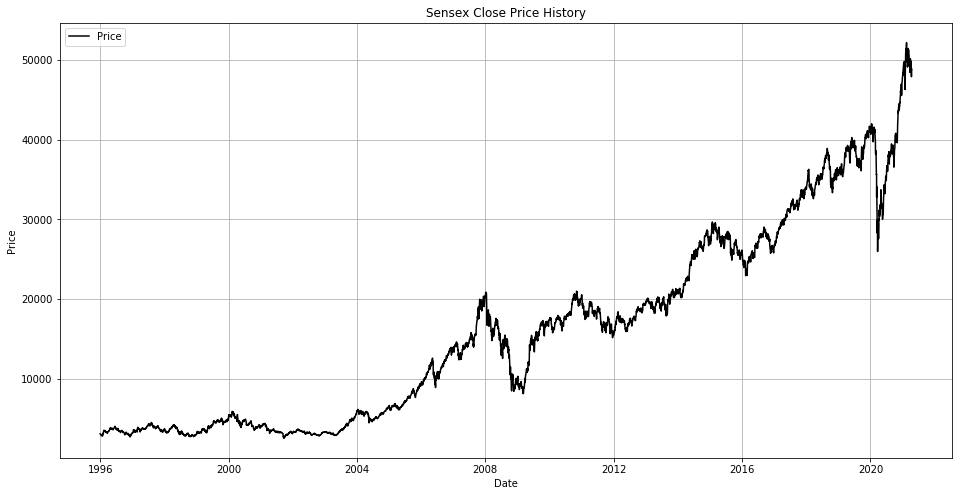

In [4]:
new_date = [dt.datetime.strptime(d,'%d-%m-%Y').date() for d in sensex['Date']]
plt.figure(figsize=(16,8))
plt.title('Sensex Close Price History')
plt.plot(new_date, sensex['Close'],label='Price', color='black')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(loc=2)

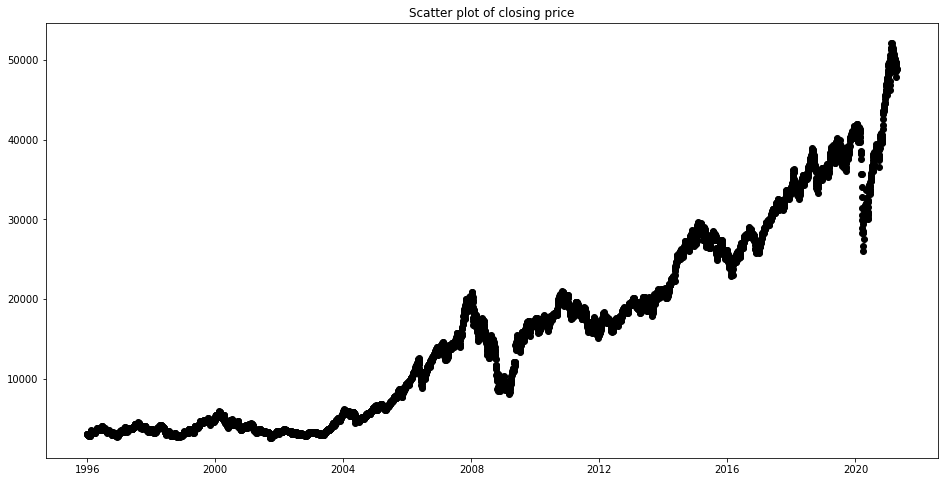

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(new_date,sensex['Close'], color='black')
plt.title('Scatter plot of closing price')
plt.show()

### Augmented Dickey Fuller Test

Testing For Stationarity on the main dataset:

To identify the nature of the data, we will be using the null hypothesis.

H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt. <b>It is non-stationary</b>

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0. <b>It is stationary</b>

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

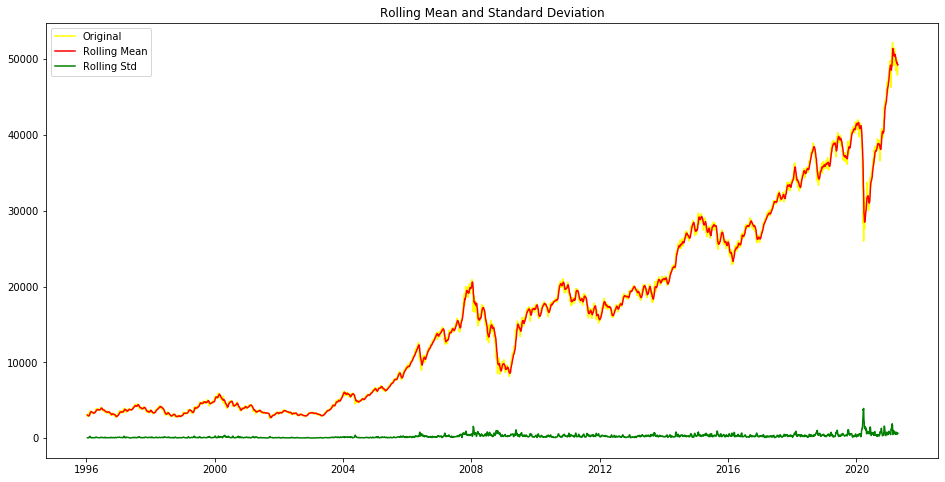

Results of dickey fuller test
Test Statistics                   0.850794
p-value                           0.992413
No. of lags used                 18.000000
Number of observations used    6254.000000
critical value (1%)              -3.431396
critical value (5%)              -2.862002
critical value (10%)             -2.567016
dtype: float64


In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(sensex['Close'])

As the p-value is greater than 0.05 so we cannot reject the <b>Null hypothesis</b>. Also, the test statistics is greater than the critical values, so the data is non-stationary.

### Logarithmic Moving Average and Standard Deviation

No handles with labels found to put in legend.


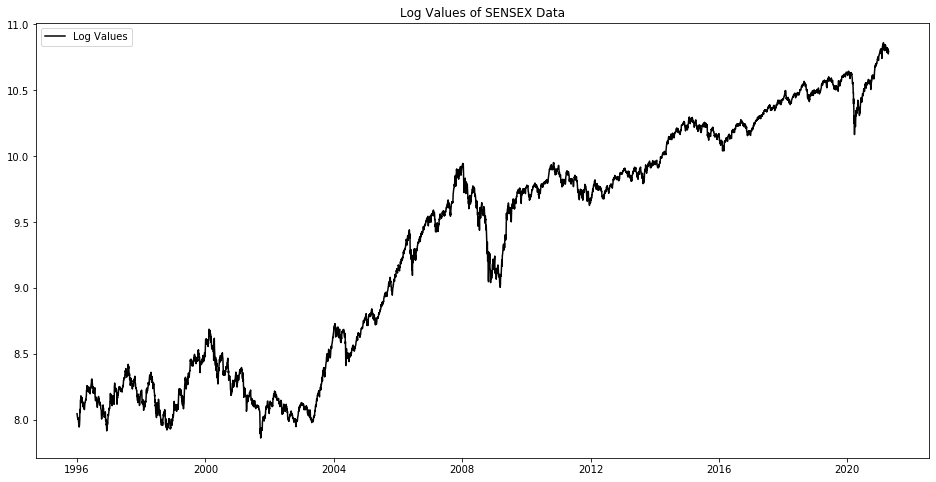

In [7]:
sensex['log_close'] = np.log(sensex['Close'])
plt.figure(figsize=(16,8))
plt.legend(loc='best')
plt.title('Log Values of SENSEX Data')
plt.plot(new_date, sensex['log_close'], color ="black", label = "Log Values")
plt.legend()
plt.show()

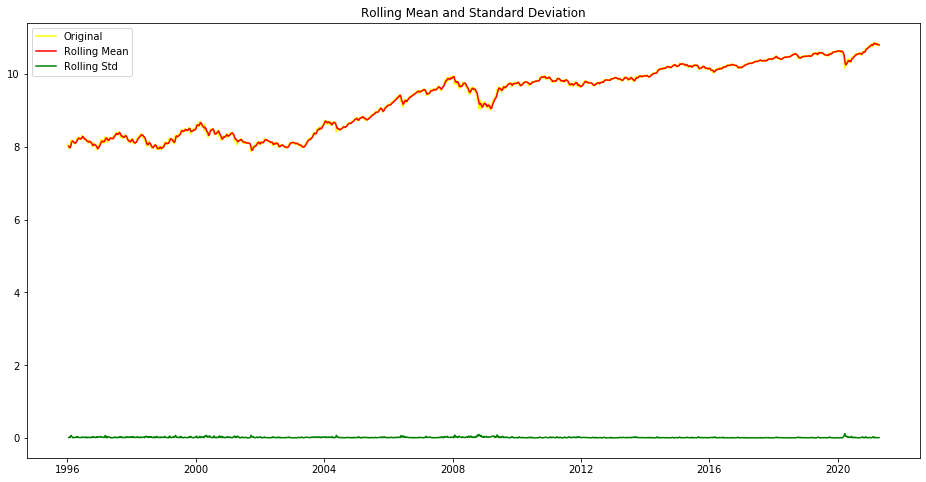

Results of dickey fuller test
Test Statistics                  -0.555194
p-value                           0.880788
No. of lags used                 20.000000
Number of observations used    6252.000000
critical value (1%)              -3.431396
critical value (5%)              -2.862002
critical value (10%)             -2.567016
dtype: float64


In [8]:
def test_stationarity_onlog(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity_onlog(sensex['log_close'])

Still, we can see that, the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values, so the data is non-stationary.

### Differencing

No handles with labels found to put in legend.


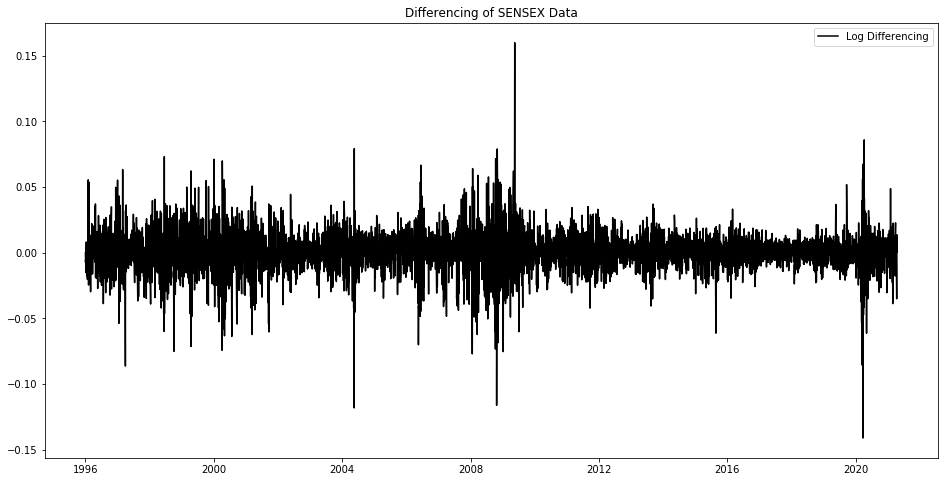

In [9]:
sensex['diff_close'] = sensex['log_close'] - sensex['log_close'].shift(1)
sensex['diff_close'] = sensex['diff_close'].fillna(0)
plt.figure(figsize=(16,8))
plt.legend(loc='best')
plt.title('Differencing of SENSEX Data')
plt.plot(new_date, sensex['diff_close'], color ="black", label = "Log Differencing")
plt.legend()
plt.show()

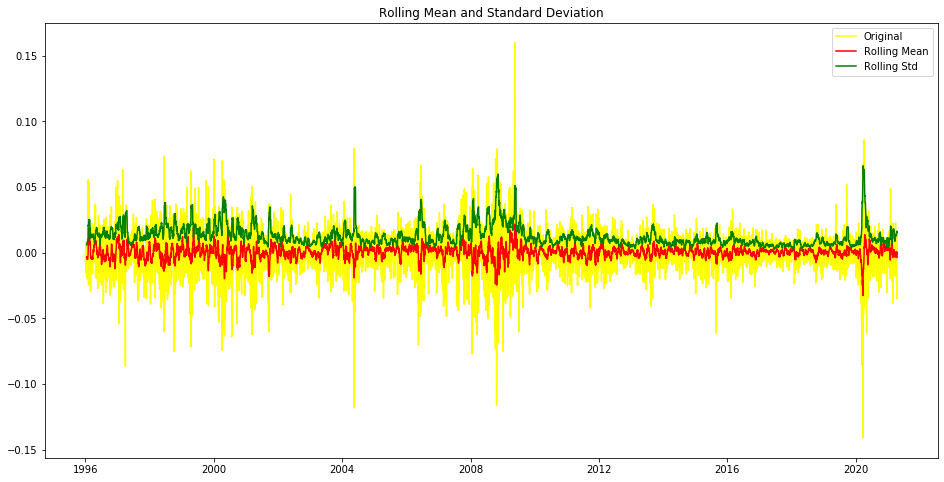

Results of dickey fuller test
Test Statistics               -1.822741e+01
p-value                        2.371763e-30
No. of lags used               1.900000e+01
Number of observations used    6.253000e+03
critical value (1%)           -3.431396e+00
critical value (5%)           -2.862002e+00
critical value (10%)          -2.567016e+00
dtype: float64


In [10]:
def test_stationarity_ondiff(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity_ondiff(sensex['diff_close'])

Now, as we can see, the p-value is lesser than 0.05 so we reject the Null hypothesis. Also, the test statistics is lesser than the critical values, so the data is stationary.

### ARIMA Model

<b>Figure out the Order of ARIMA Model</b>

In [11]:
stepwise_fit = auto_arima(sensex['diff_close'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-34800.600, Time=2.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34786.213, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34803.403, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-34804.246, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34782.947, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-34804.577, Time=1.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34802.626, Time=1.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-34802.598, Time=0.83 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-34804.621, Time=0.57 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-34802.647, Time=2.61 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-34800.756, Time=1.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-34801.718, Time=0.62 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 12.796 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6273
Model:               SARIMAX(0, 0, 2)   Log Likelihood               17406.311
Date:                Fri, 23 Apr 2021   AIC                         -34804.621
Time:                        18:25:43   BIC                         -34777.645
Sample:                             0   HQIC                        -34795.274
                               - 6273                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      2.128      0.033     3.4e-05       0.001
ma.L1          0.0565      0.007      7.658      0.000       0.042       0.071
ma.L2         -0.0190      0.007     -2.567      0.010      -0.033      -0.004
sigma2         0.0002   1.86e-06    122.118      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15179.34
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

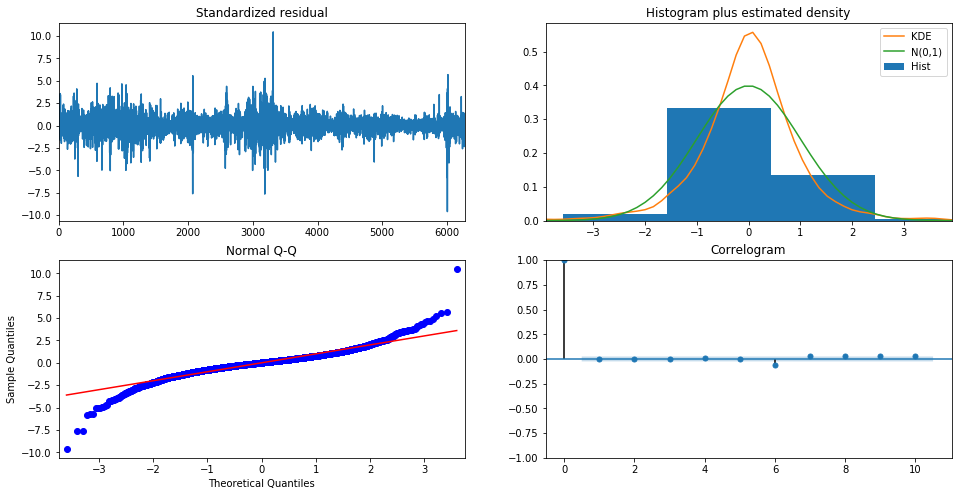

In [12]:
stepwise_fit.plot_diagnostics(figsize=(16,8))
plt.show()

<b>Split Data in training and testing dataset</b>

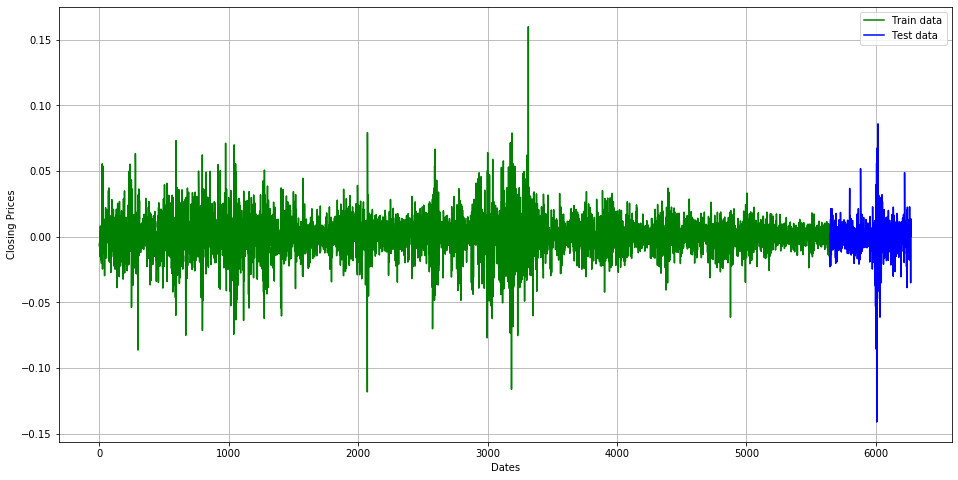

In [13]:
train_data, test_data = sensex[1:int(len(sensex)*0.9)], sensex[int(len(sensex)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['diff_close'], 'green', label='Train data')
plt.plot(test_data['diff_close'], 'blue', label='Test data')
plt.legend()

<b>Train the Model</b>

In [14]:
model = ARIMA(train_data['diff_close'], order = (0,0,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             diff_close   No. Observations:                 5644
Model:                     ARMA(0, 2)   Log Likelihood               15665.203
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 23 Apr 2021   AIC                         -31322.406
Time:                        18:25:44   BIC                         -31295.853
Sample:                             0   HQIC                        -31313.156
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0004      0.000      2.072      0.038    2.36e-05       0.001
ma.L1.diff_close     0.0729      0.013      5.483      0.000       0.047       0.099
ma.L2.diff_close    -0.0257      0.013     -1.946      0.052      -0.052       0.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -4.9773           +0.0000j            4.9773            0.5000
MA.2            7.8143           +0.0000j            7.8143            0.0000
-----------------------------------------------------------------------------
"""

<b>Make prediction for Test Data</b>

In [15]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predict = model.predict(start = start, end = end)
sensex['Predict'] = predict

<b>Turn data back to original form</b>

In [16]:
sensex['sum_pred'] = sensex['Predict'].cumsum()

In [17]:
sensex['log_pred'] = pd.Series(sensex['log_close'].iloc[start], index=sensex['log_close'].index)
sensex['log_pred'] = sensex['log_pred'].add(sensex['sum_pred'],fill_value=0)
sensex['log_pred'] = sensex['log_pred'].iloc[start:]

In [18]:
sensex['pred_value'] = np.exp(sensex['log_pred'])

### Visualization of Final Result

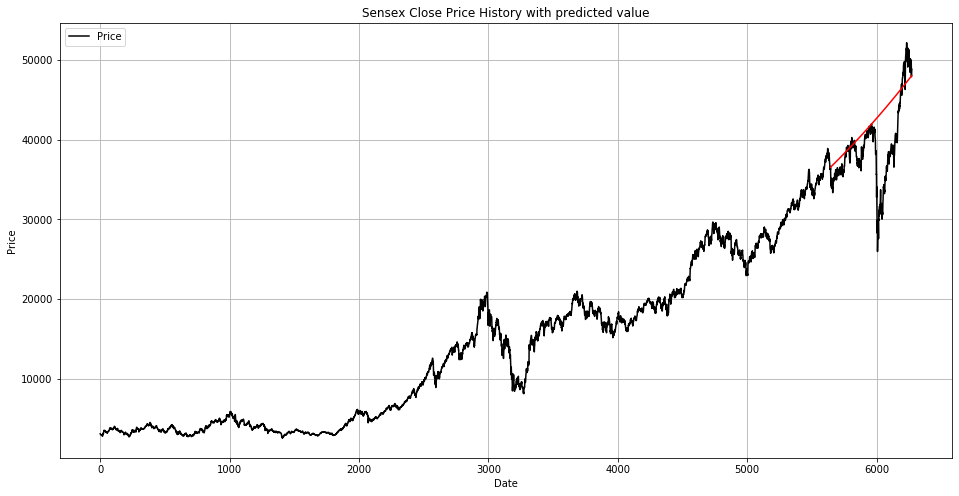

In [19]:
plt.figure(figsize=(16,8))
plt.title('Sensex Close Price History with predicted value')
plt.plot(sensex['Close'],label='Price', color='black')
plt.plot(sensex['pred_value'], color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(loc=2)

### Accuracy Tests

<b>Mean Error</b>

In [20]:
me = np.mean(sensex['Predict'].iloc[start+1:] - test_data['diff_close'])
print(me)

-2.6138417086299396e-05


<b>Mean Absolute Error</b>

In [21]:
mae = np.mean(np.abs(sensex['Predict'].iloc[start+1:] - test_data['diff_close']))
print(mae)

0.00942755670750483


<b>Mean Absolute Percentage Error</b>

In [22]:
mape = np.mean(np.abs(sensex['Predict'].iloc[start+1:] - test_data['diff_close']) / np.abs(test_data['diff_close']))
print(mape)

1.0603741777351


<b>Mean Percentage Error</b>

In [23]:
mpe = np.mean((sensex['Predict'].iloc[start+1:] - test_data['diff_close'])/test_data['diff_close'])
print(mpe)

-0.9896815741661642


<b>Root Mean Square Error</b>

In [24]:
rsme = math.sqrt(mean_squared_error(sensex['Predict'].iloc[start+1:],test_data['diff_close']))
print(rsme)

0.015068127448968528


<b>Autocorrelation of errors at lag 1</b>

In [25]:
acf1 = acf(sensex['Predict'].iloc[start+1:] - test_data['diff_close'])[1]
print(acf1)

-0.08277051266553051


<b>Correlation Coefficient</b>

In [26]:
corr = np.corrcoef(sensex['Predict'].iloc[start+1:], test_data['diff_close'])[0,1]
print(corr)

-0.021254221360852855
